In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
# from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = cifar10.load_data()

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


170498071/170498071 [==============================] - 2s 0us/step


In [ ]:

input_S = X_train[0:X_train.shape[0] // 2]

input_C = X_train[X_train.shape[0] // 2:]

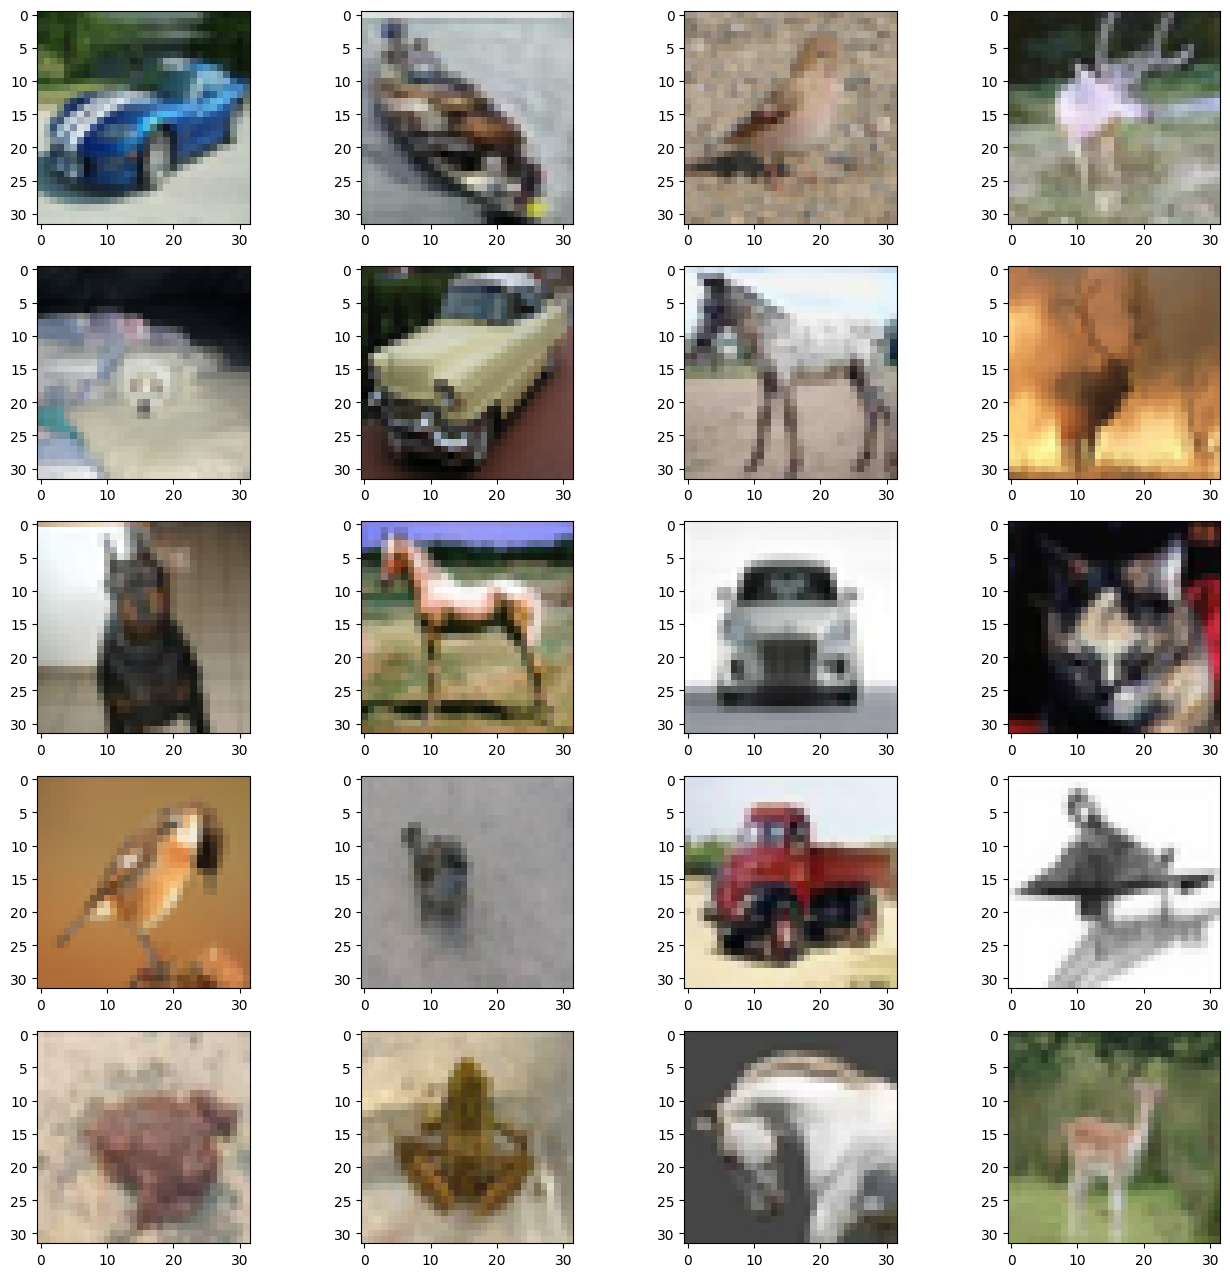

In [ ]:
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
beta = 2.0

def rev_loss(s_true, s_pred):

    return beta * K.sum(K.square(s_true - s_pred))

def full_loss(y_true, y_pred):
    (s_true, c_true) = (y_true[..., 0:3], y_true[..., 3:6])
    (s_pred, c_pred) = (y_pred[..., 0:3], y_pred[..., 3:6])
    # print("Shape of c_true:", c_true.shape)
    # print("Shape of c_pred:", c_pred.shape)
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss





In [ ]:


def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

def make_decoder(input_size, fixed=False):
    reveal_input = Input(shape=(input_size))

    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)

    input_gray = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_with_noise)

    x3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_gray)
    x4 = Conv2D(16, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_gray)
    x5 = Conv2D(8, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_gray)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(16, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(8, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(1, (3, 3), strides=(1, 1), padding='same', activation='relu', name='output_S')(x)

    if not fixed:
        return Model(inputs=reveal_input, outputs=output_Sprime, name='Decoder')
    else:
        return Model(inputs=reveal_input, outputs=output_Sprime, name='DecoderFixed')




In [ ]:
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size, fixed=True)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder



In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])


In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 1
BATCH_SIZE = 256

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)

    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:

        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

        C_prime = encoder_model.predict([batch_S, batch_C])

        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                y=[batch_S, batch_C]))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))

        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))

        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))

    autoencoder_model.save_weights('models/model'+str(epoch))

    loss_history.append(np.mean(ae_loss))

  0%|          | 0/98 [00:00<?, ?it/s]

8/8 [==============================] - 3s 13ms/step


Epoch 1 | Batch:   0 of 25000. Loss AE  447609.53 | Loss Rev  473415.06:   1%|          | 1/98 [00:27<43:40, 27.01s/it]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 256 of 25000. Loss AE  954812.14 | Loss Rev  284630.18:   2%|▏         | 2/98 [00:28<18:45, 11.72s/it]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 512 of 25000. Loss AE  714802.69 | Loss Rev  238797.94:   3%|▎         | 3/98 [00:29<10:51,  6.85s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 768 of 25000. Loss AE  599736.20 | Loss Rev  202563.94:   4%|▍         | 4/98 [00:30<07:06,  4.53s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 1024 of 25000. Loss AE  554828.86 | Loss Rev  270227.01:   5%|▌         | 5/98 [00:30<04:59,  3.22s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 1280 of 25000. Loss AE  517259.94 | Loss Rev  256166.88:   6%|▌         | 6/98 [00:31<03:43,  2.43s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 1536 of 25000. Loss AE  499120.87 | Loss Rev  262046.80:   7%|▋         | 7/98 [00:32<02:56,  1.94s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 1792 of 25000. Loss AE  483465.82 | Loss Rev  266500.19:   8%|▊         | 8/98 [00:33<02:24,  1.61s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 2048 of 25000. Loss AE  470142.37 | Loss Rev  268369.11:   9%|▉         | 9/98 [00:34<02:03,  1.39s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 2304 of 25000. Loss AE  460382.49 | Loss Rev  269229.36:  10%|█         | 10/98 [00:35<01:48,  1.24s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 2560 of 25000. Loss AE  444995.35 | Loss Rev  261536.07:  11%|█         | 11/98 [00:36<01:38,  1.13s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 2816 of 25000. Loss AE  424536.47 | Loss Rev  247464.91:  12%|█▏        | 12/98 [00:37<01:31,  1.06s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 3072 of 25000. Loss AE  414465.96 | Loss Rev  282079.37:  13%|█▎        | 13/98 [00:38<01:26,  1.02s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 3328 of 25000. Loss AE  394501.85 | Loss Rev  268758.51:  14%|█▍        | 14/98 [00:39<01:23,  1.01it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 3584 of 25000. Loss AE  378343.87 | Loss Rev  259542.09:  15%|█▌        | 15/98 [00:40<01:26,  1.04s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 3840 of 25000. Loss AE  365090.57 | Loss Rev  255544.44:  16%|█▋        | 16/98 [00:41<01:29,  1.10s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 4096 of 25000. Loss AE  351062.51 | Loss Rev  251547.76:  17%|█▋        | 17/98 [00:42<01:23,  1.04s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 4352 of 25000. Loss AE  338128.36 | Loss Rev  247116.92:  18%|█▊        | 18/98 [00:43<01:19,  1.00it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 4608 of 25000. Loss AE  328738.13 | Loss Rev  240932.84:  19%|█▉        | 19/98 [00:44<01:16,  1.04it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 4864 of 25000. Loss AE  318459.81 | Loss Rev  235331.82:  20%|██        | 20/98 [00:45<01:14,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 5120 of 25000. Loss AE  307440.59 | Loss Rev  229378.68:  21%|██▏       | 21/98 [00:46<01:12,  1.07it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 5376 of 25000. Loss AE  296952.92 | Loss Rev  223097.79:  22%|██▏       | 22/98 [00:46<01:10,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 5632 of 25000. Loss AE  287242.12 | Loss Rev  216640.70:  23%|██▎       | 23/98 [00:47<01:09,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 5888 of 25000. Loss AE  278789.32 | Loss Rev  212325.26:  24%|██▍       | 24/98 [00:48<01:08,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 6144 of 25000. Loss AE  270733.99 | Loss Rev  207690.75:  26%|██▌       | 25/98 [00:49<01:06,  1.09it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 6400 of 25000. Loss AE  262825.93 | Loss Rev  202747.39:  27%|██▋       | 26/98 [00:50<01:06,  1.09it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 6656 of 25000. Loss AE  255097.05 | Loss Rev  197867.88:  28%|██▊       | 27/98 [00:51<01:04,  1.10it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 6912 of 25000. Loss AE  247811.97 | Loss Rev  192974.14:  29%|██▊       | 28/98 [00:52<01:08,  1.02it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 7168 of 25000. Loss AE  240977.87 | Loss Rev  188514.97:  30%|██▉       | 29/98 [00:53<01:07,  1.03it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 7424 of 25000. Loss AE  234718.43 | Loss Rev  184689.20:  31%|███       | 30/98 [00:54<01:05,  1.04it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 7680 of 25000. Loss AE  228796.69 | Loss Rev  180750.65:  32%|███▏      | 31/98 [00:55<01:03,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 7936 of 25000. Loss AE  223192.13 | Loss Rev  177292.79:  33%|███▎      | 32/98 [00:56<01:01,  1.07it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 8192 of 25000. Loss AE  217659.13 | Loss Rev  173587.28:  34%|███▎      | 33/98 [00:57<01:00,  1.07it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 8448 of 25000. Loss AE  212410.82 | Loss Rev  169864.91:  35%|███▍      | 34/98 [00:58<00:59,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 8704 of 25000. Loss AE  207499.66 | Loss Rev  166414.73:  36%|███▌      | 35/98 [00:59<00:58,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 8960 of 25000. Loss AE  202756.67 | Loss Rev  163169.92:  37%|███▋      | 36/98 [01:00<00:57,  1.08it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 9216 of 25000. Loss AE  198321.95 | Loss Rev  160337.89:  38%|███▊      | 37/98 [01:00<00:56,  1.09it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 9472 of 25000. Loss AE  193987.72 | Loss Rev  157191.18:  39%|███▉      | 38/98 [01:01<00:54,  1.09it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 9728 of 25000. Loss AE  189805.16 | Loss Rev  154169.99:  40%|███▉      | 39/98 [01:02<00:54,  1.09it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 9984 of 25000. Loss AE  185884.59 | Loss Rev  151304.31:  41%|████      | 40/98 [01:03<00:55,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 10240 of 25000. Loss AE  182111.22 | Loss Rev  148551.99:  42%|████▏     | 41/98 [01:05<00:59,  1.04s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 10496 of 25000. Loss AE  178523.40 | Loss Rev  146042.44:  43%|████▎     | 42/98 [01:05<00:55,  1.00it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 10752 of 25000. Loss AE  175042.20 | Loss Rev  143538.21:  44%|████▍     | 43/98 [01:06<00:53,  1.02it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 11008 of 25000. Loss AE  171711.69 | Loss Rev  141058.41:  45%|████▍     | 44/98 [01:07<00:51,  1.04it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 11264 of 25000. Loss AE  168465.22 | Loss Rev  138660.43:  46%|████▌     | 45/98 [01:08<00:50,  1.06it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 11520 of 25000. Loss AE  165367.74 | Loss Rev  136360.68:  47%|████▋     | 46/98 [01:09<00:48,  1.07it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 11776 of 25000. Loss AE  162381.08 | Loss Rev  134183.73:  48%|████▊     | 47/98 [01:10<00:47,  1.07it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 12032 of 25000. Loss AE  159508.36 | Loss Rev  132090.49:  49%|████▉     | 48/98 [01:11<00:46,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 12288 of 25000. Loss AE  156717.73 | Loss Rev  129989.75:  50%|█████     | 49/98 [01:12<00:45,  1.08it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 12544 of 25000. Loss AE  154054.49 | Loss Rev  127998.37:  51%|█████     | 50/98 [01:13<00:46,  1.03it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 12800 of 25000. Loss AE  151493.51 | Loss Rev  126057.26:  52%|█████▏    | 51/98 [01:14<00:44,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 13056 of 25000. Loss AE  149025.97 | Loss Rev  124182.54:  53%|█████▎    | 52/98 [01:15<00:46,  1.02s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 13312 of 25000. Loss AE  146634.28 | Loss Rev  122376.32:  54%|█████▍    | 53/98 [01:16<00:47,  1.05s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 13568 of 25000. Loss AE  144319.63 | Loss Rev  120612.55:  55%|█████▌    | 54/98 [01:17<00:44,  1.02s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 13824 of 25000. Loss AE  142102.88 | Loss Rev  118932.72:  56%|█████▌    | 55/98 [01:18<00:42,  1.01it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 14080 of 25000. Loss AE  139934.84 | Loss Rev  117269.10:  57%|█████▋    | 56/98 [01:19<00:41,  1.02it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 14336 of 25000. Loss AE  137822.59 | Loss Rev  115636.52:  58%|█████▊    | 57/98 [01:20<00:39,  1.04it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 14592 of 25000. Loss AE  135777.46 | Loss Rev  114081.84:  59%|█████▉    | 58/98 [01:21<00:38,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 14848 of 25000. Loss AE  133779.19 | Loss Rev  112533.01:  60%|██████    | 59/98 [01:22<00:37,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 15104 of 25000. Loss AE  131887.84 | Loss Rev  111074.58:  61%|██████    | 60/98 [01:23<00:35,  1.06it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 15360 of 25000. Loss AE  130028.05 | Loss Rev  109629.11:  62%|██████▏   | 61/98 [01:24<00:34,  1.06it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 15616 of 25000. Loss AE  128233.60 | Loss Rev  108227.11:  63%|██████▎   | 62/98 [01:25<00:35,  1.01it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 15872 of 25000. Loss AE  126486.05 | Loss Rev  106865.90:  64%|██████▍   | 63/98 [01:26<00:34,  1.03it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 16128 of 25000. Loss AE  124792.19 | Loss Rev  105537.62:  65%|██████▌   | 64/98 [01:27<00:35,  1.04s/it]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 16384 of 25000. Loss AE  123148.93 | Loss Rev  104249.86:  66%|██████▋   | 65/98 [01:28<00:35,  1.07s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 16640 of 25000. Loss AE  121535.43 | Loss Rev  102974.47:  67%|██████▋   | 66/98 [01:29<00:32,  1.03s/it]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 16896 of 25000. Loss AE  119980.01 | Loss Rev  101760.21:  68%|██████▊   | 67/98 [01:30<00:30,  1.00it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 17152 of 25000. Loss AE  118458.80 | Loss Rev  100555.76:  69%|██████▉   | 68/98 [01:31<00:29,  1.02it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 17408 of 25000. Loss AE  116971.86 | Loss Rev   99374.18:  70%|███████   | 69/98 [01:32<00:27,  1.04it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 17664 of 25000. Loss AE  115541.67 | Loss Rev   98238.99:  71%|███████▏  | 70/98 [01:33<00:26,  1.05it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 17920 of 25000. Loss AE  114147.49 | Loss Rev   97136.36:  72%|███████▏  | 71/98 [01:34<00:25,  1.06it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 18176 of 25000. Loss AE  112758.79 | Loss Rev   96023.96:  73%|███████▎  | 72/98 [01:35<00:24,  1.06it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 18432 of 25000. Loss AE  111444.63 | Loss Rev   94981.09:  74%|███████▍  | 73/98 [01:35<00:23,  1.06it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 18688 of 25000. Loss AE  110156.30 | Loss Rev   93955.60:  76%|███████▌  | 74/98 [01:36<00:22,  1.06it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 18944 of 25000. Loss AE  108895.71 | Loss Rev   92954.39:  77%|███████▋  | 75/98 [01:37<00:21,  1.06it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 19200 of 25000. Loss AE  107677.99 | Loss Rev   91990.50:  78%|███████▊  | 76/98 [01:38<00:21,  1.03it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 19456 of 25000. Loss AE  106472.58 | Loss Rev   91027.98:  79%|███████▊  | 77/98 [01:39<00:20,  1.00it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 19712 of 25000. Loss AE  105298.47 | Loss Rev   90094.12:  80%|███████▉  | 78/98 [01:40<00:19,  1.00it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 19968 of 25000. Loss AE  104140.77 | Loss Rev   89161.88:  81%|████████  | 79/98 [01:41<00:18,  1.01it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 20224 of 25000. Loss AE  103018.61 | Loss Rev   88263.55:  82%|████████▏ | 80/98 [01:42<00:17,  1.03it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 20480 of 25000. Loss AE  101939.40 | Loss Rev   87404.75:  83%|████████▎ | 81/98 [01:43<00:16,  1.04it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 20736 of 25000. Loss AE  100869.61 | Loss Rev   86551.24:  84%|████████▎ | 82/98 [01:44<00:15,  1.04it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 20992 of 25000. Loss AE   99818.09 | Loss Rev   85710.03:  85%|████████▍ | 83/98 [01:45<00:14,  1.05it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 21248 of 25000. Loss AE   98796.47 | Loss Rev   84897.69:  86%|████████▌ | 84/98 [01:46<00:13,  1.05it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 21504 of 25000. Loss AE   97787.91 | Loss Rev   84092.47:  87%|████████▋ | 85/98 [01:47<00:12,  1.05it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 21760 of 25000. Loss AE   96807.01 | Loss Rev   83309.95:  88%|████████▊ | 86/98 [01:48<00:11,  1.06it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 22016 of 25000. Loss AE   95837.38 | Loss Rev   82531.22:  89%|████████▉ | 87/98 [01:49<00:10,  1.06it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 22272 of 25000. Loss AE   94889.30 | Loss Rev   81770.54:  90%|████████▉ | 88/98 [01:50<00:09,  1.04it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 22528 of 25000. Loss AE   93971.83 | Loss Rev   81041.16:  91%|█████████ | 89/98 [01:51<00:08,  1.01it/s]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 22784 of 25000. Loss AE   93060.60 | Loss Rev   80317.11:  92%|█████████▏| 90/98 [01:52<00:08,  1.07s/it]

8/8 [==============================] - 0s 14ms/step


Epoch 1 | Batch: 23040 of 25000. Loss AE   92170.57 | Loss Rev   79603.90:  93%|█████████▎| 91/98 [01:53<00:07,  1.04s/it]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 23296 of 25000. Loss AE   91299.84 | Loss Rev   78909.32:  94%|█████████▍| 92/98 [01:54<00:06,  1.01s/it]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 23552 of 25000. Loss AE   90448.38 | Loss Rev   78228.36:  95%|█████████▍| 93/98 [01:55<00:04,  1.00it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 23808 of 25000. Loss AE   89616.12 | Loss Rev   77566.61:  96%|█████████▌| 94/98 [01:56<00:03,  1.02it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 24064 of 25000. Loss AE   88805.47 | Loss Rev   76920.86:  97%|█████████▋| 95/98 [01:57<00:02,  1.02it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 24320 of 25000. Loss AE   88021.01 | Loss Rev   76300.61:  98%|█████████▊| 96/98 [01:58<00:01,  1.03it/s]

8/8 [==============================] - 0s 15ms/step


Epoch 1 | Batch: 24576 of 25000. Loss AE   87246.85 | Loss Rev   75682.70:  99%|█████████▉| 97/98 [01:59<00:00,  1.04it/s]

6/6 [==============================] - 1s 84ms/step


Epoch 1 | Batch: 24832 of 25000. Loss AE   86431.59 | Loss Rev   75009.60: 100%|██████████| 98/98 [02:09<00:00,  1.32s/it]


In [ ]:
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

782/782 [==============================] - 22s 27ms/step


In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(13, 3))
    a=fig.add_subplot(1,2,1)

    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 22.887135
C error per pixel [0, 255]: 135.97234


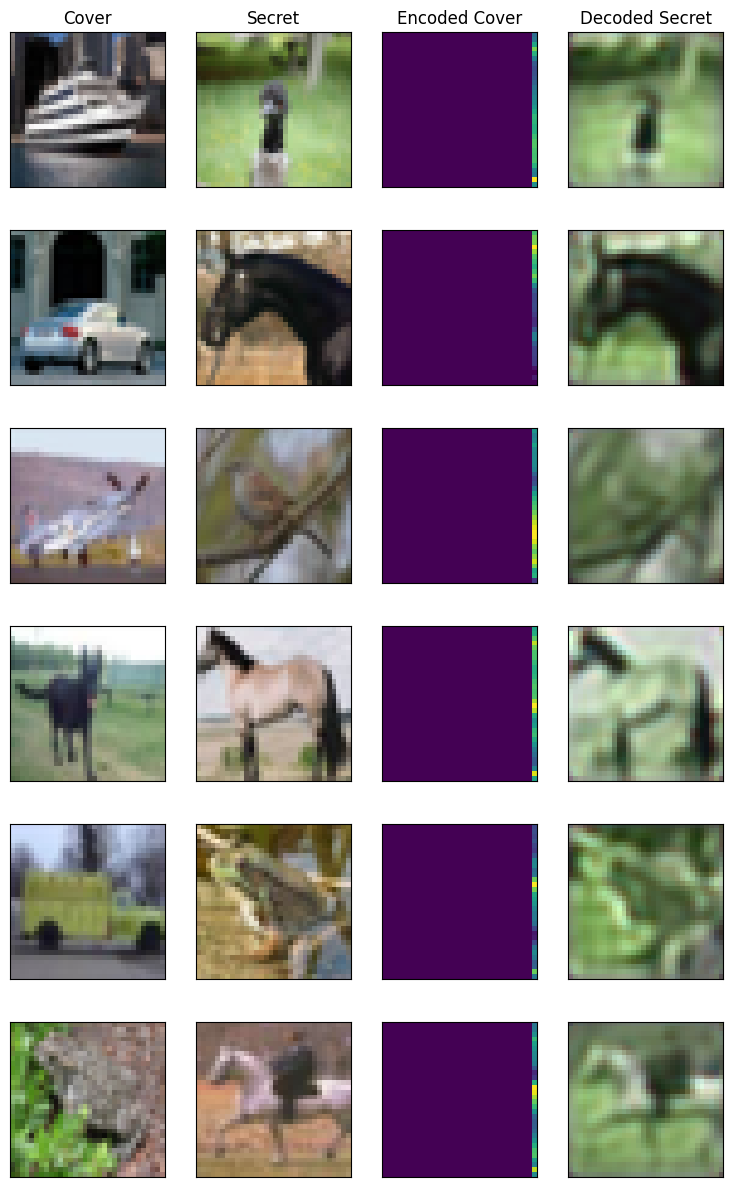

In [ ]:

SHOW_GRAY = False
SHOW_DIFF = True

ENHANCE = 1

n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')



plt.show()

In [ ]:
import cv2
import numpy as np

secret_image = cv2.imread('/content/Narendra Modi.jpeg')
cover_image = cv2.imread('/content/Anushka Sharma.jpeg')

secret_image = cv2.resize(secret_image, (2048, 2048),cv2.COLOR_BGR2RGB)
cover_image = cv2.resize(cover_image, (2048, 2048))
secret_image = cv2.cvtColor(secret_image, cv2.COLOR_BGR2RGB)
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2RGB)
secret_image1 = secret_image.astype('float32') / 255.0
cover_image1 = cover_image.astype('float32') / 255.0

input_S = np.expand_dims(secret_image1, axis=0)
input_C = np.expand_dims(cover_image1, axis=0)


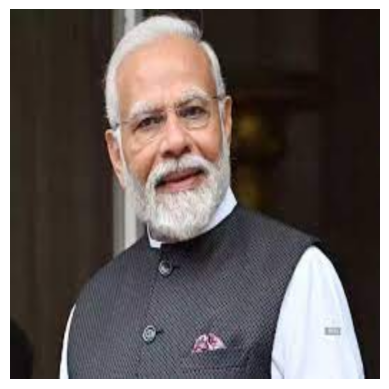

In [ ]:
plt.imshow(secret_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C])
# decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
decoded_S = decoded[...,0:3]

# diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

1/1 [==============================] - 3s 3s/step


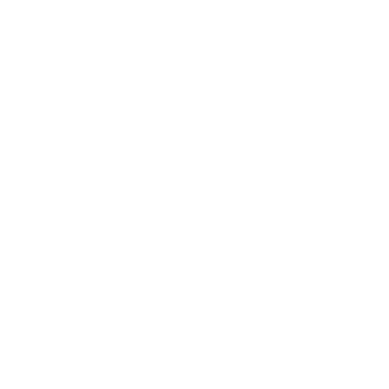

In [ ]:
import matplotlib.pyplot as plt

# Normalize the image data to be in the range [0, 1]
# normalized_decoded = decoded[0] / decoded[0].max()

# Plot the normalized decoded image
plt.imshow(decoded[0])
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

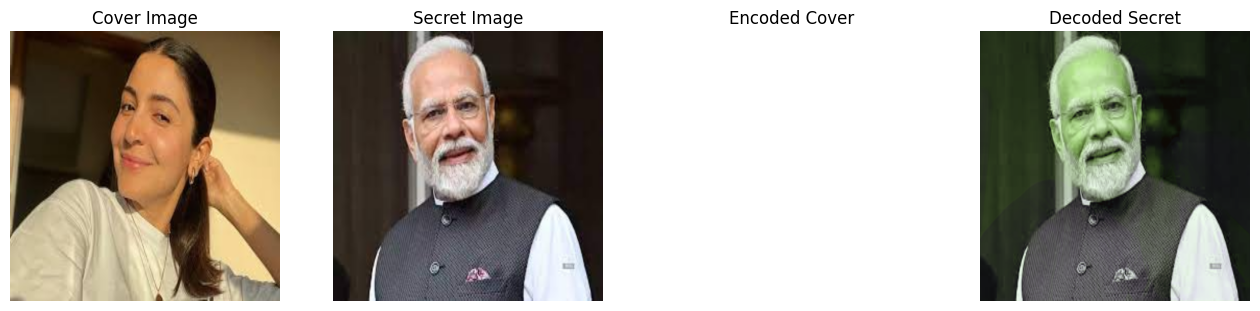

In [ ]:
import matplotlib.pyplot as plt

def show_images1(cover_image, secret_image, encoded_cover, decoded_secret):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    cover_image = cover_image.squeeze()
    secret_image = secret_image.squeeze()
    # extracted_cover = extracted_cover.squeeze()
    encoded_cover = encoded_cover.squeeze()
    decoded_secret = decoded_secret.squeeze()

    axes[0].imshow(cover_image)
    axes[0].set_title('Cover Image')
    axes[0].axis('off')

    axes[1].imshow(secret_image)
    axes[1].set_title('Secret Image')
    axes[1].axis('off')

    axes[2].imshow(encoded_cover)
    axes[2].set_title('Encoded Cover')
    axes[2].axis('off')


    # axes[3].imshow(extracted_cover)
    # axes[3].set_title('extracted Cover')
    # axes[3].axis('off')



    # Normalize decoded_secret once
    decoded_secret_normalized = decoded_secret / decoded_secret.max()
    axes[3].imshow(decoded_secret_normalized)
    axes[3].set_title('Decoded Secret')
    axes[3].axis('off')



    plt.show()

show_images1(input_C, input_S, decoded[0],decoded_S)
